## This notebook is going to be used for the Capstone project.

In [1]:
import pandas as pd
import numpy as np
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


In [2]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

### Introduction of the Business problem

#### Intro
I will explore the best location for a new coffee shop in Queens, NY. Queens is an up-and-coming borough with an emerging coffee culture.

#### Target group
Entrepreneurs looking to invest to a coffee house.
Data scientists looking for common applications of foursquare data.

### Data section

For this project we need the following data:
1. New York City data that contains Borough, Neighborhoods along with there latitudes and longitudes
Data Source: https://cocl.us/new_york_dataset
Description: This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.
2. Coffee shops in Queens neighborhood of new york city.
Data Source: Foursquare API
Description: By using this API we will get all the venues in the Queens neighborhood. We can filter these venues to get only coffee shops.

### Approach
Collect the new york city data from https://cocl.us/new_york_dataset. <br>
Using Foursquare API we will get all venues for each neighborhood.<br>
Filter out all venues which are coffee shops.<br>
Data Visualization and some statistical analysis.<br>
Analyzing using Clustering (especially K-Means): Find the best value of K and Visualize the neighborhood with a number of coffee shops.<br>
Compare the Neighborhoods to Find the Best Place for Starting up a cafe.<br>
Inference From these Results and related Conclusions

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [4]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


'wget' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
queens_data = neighborhoods[neighborhoods['Borough'] == 'Queens'].reset_index(drop=True)
queens_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


In [8]:
address = 'Queens, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Queens are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Queens are 40.7498243, -73.7976337.


### Using Foursquare Location Data
For this business problem I have used, as a part of the assignment, the Foursquare API to retrieve information about the Venue, Venue category with their longitudes and latitudes.

In [9]:
CLIENT_ID = 'J0BZW5GEJSIH4SS0YGQE1XZ3WZZ0ELEX1BCDBYJ1EH4XQSGS' # your Foursquare ID
CLIENT_SECRET = '3EAW2F3JBH3HEJARJFHXLRGNKPZRQIJKFHITVNY0MXHFPUZ2' # your Foursquare Secret
ACCESS_TOKEN = 'HVGIQR4OEMBZUULL2CURS4VWKRWTHPDZEHOKV1XCTNVIQA5U' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: J0BZW5GEJSIH4SS0YGQE1XZ3WZZ0ELEX1BCDBYJ1EH4XQSGS
CLIENT_SECRET:3EAW2F3JBH3HEJARJFHXLRGNKPZRQIJKFHITVNY0MXHFPUZ2


In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
queens_venues = getNearbyVenues(names=queens_data['Neighborhood'],
                                   latitudes=queens_data['Latitude'],
                                   longitudes=queens_data['Longitude']
                                  )

Astoria
Woodside
Jackson Heights
Elmhurst
Howard Beach
Corona
Forest Hills
Kew Gardens
Richmond Hill
Flushing
Long Island City
Sunnyside
East Elmhurst
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
Ozone Park
South Ozone Park
College Point
Whitestone
Bayside
Auburndale
Little Neck
Douglaston
Glen Oaks
Bellerose
Kew Gardens Hills
Fresh Meadows
Briarwood
Jamaica Center
Oakland Gardens
Queens Village
Hollis
South Jamaica
St. Albans
Rochdale
Springfield Gardens
Cambria Heights
Rosedale
Far Rockaway
Broad Channel
Breezy Point
Steinway
Beechhurst
Bay Terrace
Edgemere
Arverne
Rockaway Beach
Neponsit
Murray Hill
Floral Park
Holliswood
Jamaica Estates
Queensboro Hill
Hillcrest
Ravenswood
Lindenwood
Laurelton
Lefrak City
Belle Harbor
Rockaway Park
Somerville
Brookville
Bellaire
North Corona
Forest Hills Gardens
Jamaica Hills
Utopia
Pomonok
Astoria Heights
Hunters Point
Sunnyside Gardens
Blissville
Roxbury
Middle Village
Malba
Hammels
Bayswater
Queensbridge


In [12]:
queens_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
1,Astoria,40.768509,-73.915654,Orange Blossom,40.769856,-73.917012,Gourmet Shop
2,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop
3,Astoria,40.768509,-73.915654,Off The Hook,40.767200,-73.918104,Seafood Restaurant
4,Astoria,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym


In [13]:
# one hot encoding
queens_onehot = pd.get_dummies(queens_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
queens_onehot['Neighborhood'] = queens_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [queens_onehot.columns[-1]] + list(queens_onehot.columns[:-1])
queens_onehot = queens_onehot[fixed_columns]
queens_grouped = queens_onehot.groupby('Neighborhood').mean().reset_index()
queens_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Beach Bar,Beer Garden,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Cafeteria,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Nail Salon,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Post Office,Pub,Ramen Restaurant,Recreation Center,Rental Car Location,Rental Service,Resort,Rest Area,Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,State / Provincial Park,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Sto

I will add together Cafe and Coffee Shop columns because they are the same thing.

In [14]:
queens_grouped['Coffee place'] = queens_grouped['Café'] + queens_grouped['Coffee Shop']

In [15]:
queens_cafe = queens_grouped[['Neighborhood', 'Coffee place']]
queens_cafe.head()

,Neighborhood,Coffee place
0,Arverne,0.100000
1,Astoria,0.050000
2,Astoria Heights,0.000000
3,Auburndale,0.000000
4,Bay Terrace,0.027778


### Select optimal number of clusters using the Elbow method

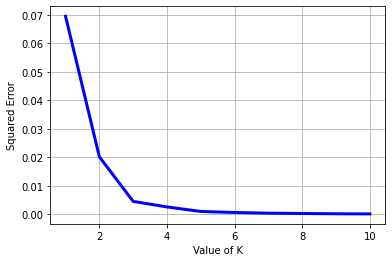

In [16]:
cost = []
for i in range(1,11):
    KM = KMeans(n_clusters = i, max_iter = 500)
    KM.fit(queens_cafe.drop('Neighborhood', 1))
    # calculate squared error
    cost.append(KM.inertia_)
    
# plot the cost against K values
plt.plot(range(1,11), cost, color = 'b', linewidth='3')
plt.xlabel('Value of K')
plt.ylabel('Squared Error')
plt.grid()
plt.show()

In [17]:
# set number of clusters
kclusters = 3

queens_grouped_clustering = queens_cafe.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(queens_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 2, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 0, 0, 0, 1])

In [18]:
# add clustering labels
queens_cafe.insert(0, 'Cluster Labels', kmeans.labels_)

queens_merged = queens_data

# merge toronto_grouped with central to add latitude/longitude for each neighborhood
queens_merged = queens_merged.join(queens_cafe.set_index('Neighborhood'), on='Neighborhood')
queens_merged.dropna(0, inplace=True)
queens_merged['Cluster Labels']=queens_merged['Cluster Labels'].astype('int32')
queens_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Coffee place
0,Queens,Astoria,40.768509,-73.915654,1,0.050000
1,Queens,Woodside,40.746349,-73.901842,1,0.039474
2,Queens,Jackson Heights,40.751981,-73.882821,1,0.025316
3,Queens,Elmhurst,40.744049,-73.881656,0,0.000000
4,Queens,Howard Beach,40.654225,-73.838138,0,0.000000
5,Queens,Corona,40.742382,-73.856825,0,0.000000
6,Queens,Forest Hills,40.725264,-73.844475,1,0.025641
7,Queens,Kew Gardens,40.705179,-73.829819,1,0.020408
8,Queens,Richmond Hill,40.697947,-73.831833,0,0.000000
9,Queens,Flushing,40.764454,-73.831773,1,0.032258


### Visualisation using Folium

In [19]:
address = 'Queens, NY'

geolocator = Nominatim(user_agent="queens_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Queens are {}, {}.'.format(latitude, longitude))
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(queens_merged['Latitude'], queens_merged['Longitude'], queens_merged['Neighborhood'], queens_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geographical coordinate of Queens are 40.7498243, -73.7976337.


In [20]:
queens_merged.loc[queens_merged['Cluster Labels'] == 0]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Coffee place
3,Queens,Elmhurst,40.744049,-73.881656,0,0.000000
4,Queens,Howard Beach,40.654225,-73.838138,0,0.000000
5,Queens,Corona,40.742382,-73.856825,0,0.000000
8,Queens,Richmond Hill,40.697947,-73.831833,0,0.000000
13,Queens,Maspeth,40.725427,-73.896217,0,0.000000
15,Queens,Glendale,40.702762,-73.870742,0,0.000000
17,Queens,Woodhaven,40.689887,-73.858110,0,0.000000
19,Queens,South Ozone Park,40.668550,-73.809865,0,0.000000
21,Queens,Whitestone,40.781291,-73.814202,0,0.000000
22,Queens,Bayside,40.766041,-73.774274,0,0.013889


In [21]:
queens_merged.loc[queens_merged['Cluster Labels'] == 1]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Coffee place
0,Queens,Astoria,40.768509,-73.915654,1,0.050000
1,Queens,Woodside,40.746349,-73.901842,1,0.039474
2,Queens,Jackson Heights,40.751981,-73.882821,1,0.025316
6,Queens,Forest Hills,40.725264,-73.844475,1,0.025641
7,Queens,Kew Gardens,40.705179,-73.829819,1,0.020408
9,Queens,Flushing,40.764454,-73.831773,1,0.032258
11,Queens,Sunnyside,40.740176,-73.926916,1,0.046512
14,Queens,Ridgewood,40.708323,-73.901435,1,0.050000
16,Queens,Rego Park,40.728974,-73.857827,1,0.023256
18,Queens,Ozone Park,40.680708,-73.843203,1,0.025000


In [22]:
queens_merged.loc[queens_merged['Cluster Labels'] == 2]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Coffee place
10,Queens,Long Island City,40.750217,-73.939202,2,0.126761
12,Queens,East Elmhurst,40.764073,-73.867041,2,0.076923
30,Queens,Briarwood,40.710935,-73.811748,2,0.090909
44,Queens,Steinway,40.775923,-73.902290,2,0.083333
48,Queens,Arverne,40.589144,-73.791992,2,0.100000
72,Queens,Hunters Point,40.743414,-73.953868,2,0.117647


### Result

Cluster 0 has the lowest frequency of coffee places. I will pick Queensbridge, because it is the one closest to Manhattan.